In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import transforms
from src.data_loader import get_data_loader
from src.utils import Config

In [3]:
from PIL import Image
import numpy as np

In [4]:
import os
import torch
from src.model import EncoderCNN, DecoderRNN

In [5]:
transform_test = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))
                                    ])

In [6]:
config = Config("config.yaml")

/home/sankarshan/Documents/code/image_captioning/src/utils.py:11: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f,) #Loader=yaml.FullLoader


In [7]:
print(config)

{'config': {'DATA_DIR': 'data/main_caption_data/', 'CAPTION_DATA_DIR': 'data/main_caption_data/', 'CAPTION_FILE': 'data/main_caption_data/Flickr8k_token_processed_flat.csv', 'IMAGE_ID_FILE_TRAIN': 'data/main_caption_data/Flickr_8k.trainImages.txt', 'IMAGE_ID_FILE_VAL': 'data/main_caption_data/Flickr_8k.devImages.txt', 'IMAGE_ID_FILE_TEST': 'data/main_caption_data/Flickr_8k.testImages.txt', 'IMAGE_DATA_DIR': 'data/images/', 'MODEL_DIR': 'model/', 'DEV_MODE': False, 'BATCH_SIZE': 64, 'VOCAB_THRESHOLD': 5, 'IMG_EMBED_SIZE': 300, 'WORD_EMBED_SIZE': 300, 'HIDDEN_SIZE': 512, 'NUM_EPOCHS': 1, 'SAVE_EVERY': 1, 'PRINT_EVERY': 5, 'VERBOSE': True, 'VOCAB_FILE': 'output/vocab.pkl', 'VOCAB_FROM_FILE': False}}


In [8]:
config.IMAGE_ID_FILE_TEST

'data/main_caption_data/Flickr_8k.testImages.txt'

# Step 1: Get Data Loader for Test Dataset

In [9]:
# Create the data loader.
test_data_loader = get_data_loader(transform=transform_test,
                                   caption_file=config.CAPTION_FILE,
                                   image_id_file=config.IMAGE_ID_FILE_TEST, 
                                   image_folder=config.IMAGE_DATA_DIR, 
                                   config=config,
                                   mode='test')

Vocabulary successfully loaded from external file output/vocab.pkl...


In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(test_data_loader))

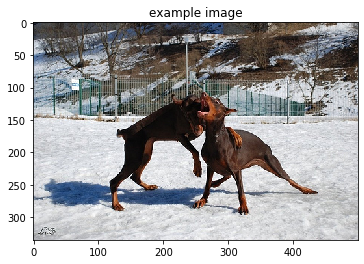

In [12]:
# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

# Step 2: Load Trained Models

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# TODO #2: Specify the saved models to load.
encoder_file = f"{config.MODEL_DIR}encoder-1.pkl"
decoder_file = f"{config.MODEL_DIR}decoder-1.pkl"

In [15]:
# TODO #3: Select appropriate values for the Python variables below.
embed_size = config.IMG_EMBED_SIZE
hidden_size = config.HIDDEN_SIZE

In [16]:
# The size of the vocabulary.
vocab_size = len(test_data_loader.dataset.vocab)

In [17]:
# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval();

In [18]:
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

DecoderRNN(
  (embedding_layer): Embedding(2549, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2549, bias=True)
)

In [19]:
# Load the trained weights.
encoder.load_state_dict(torch.load(encoder_file, map_location=device))
decoder.load_state_dict(torch.load(decoder_file, map_location=device))

<All keys matched successfully>

In [20]:
# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embedding_layer): Embedding(2549, 300)
  (lstm): LSTM(300, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2549, bias=True)
)

# Step 3: Finish the Sampler

In [21]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# image = image.squeeze(0)
# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.predict_token_ids(features)
print('example output:', output)

example output: [0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [22]:
assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in test_data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

# Step 4: Clean up the Captions

In the code cell below, complete the clean_sentence function. It should take a list of integers (corresponding to the variable output in Step 3) as input and return the corresponding predicted sentence (as a single Python string).

In [23]:
# TODO #4: Complete the function.
def clean_sentence(output):
    
    words_sequence = []
    
    for i in output:
        if (i == 1):
            continue
        words_sequence.append(test_data_loader.dataset.vocab.idx2word[i])
    
    # words_sequence = words_sequence[1:-1] 
    sentence = ' '.join(words_sequence) 
    # sentence = sentence.capitalize()
    
    return sentence


In [24]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: <start> a a a a a a a a a a a a a a a a a a a


# Step 5: Generate Predictions!

In the code cell below, we have written a function (get_prediction) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [25]:
def get_prediction():
    orig_image, image = next(iter(test_data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    print(image.size())
    features = encoder(image).unsqueeze(1)
    output = decoder.predict_token_ids(features)    
    sentence = clean_sentence(output)
    print(sentence)

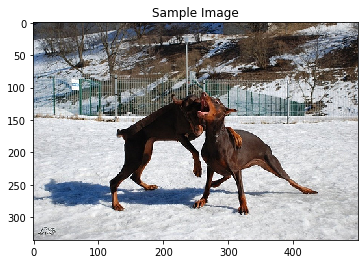

torch.Size([1, 3, 224, 224])
<start> a a a a a a a a a a a a a a a a a a a


In [26]:
get_prediction()

In [27]:
def display_image(image_file:str):
    PIL_image = Image.open(image_file).convert("RGB")
    original_image = np.array(PIL_image)
      
    plt.imshow(np.squeeze(original_image))
    plt.title('Sample Image')
    plt.show()
    
    return PIL_image

In [31]:
def predict_from_image(image_file: str):
    PIL_image = display_image(image_file)
    transformed_image = transform_test(PIL_image)  
    transformed_image = transformed_image.to(device)
    transformed_image = transformed_image.unsqueeze(dim=0) # convert size [3, 224, 224] -> [1, 3, 224, 224]
    features = encoder(transformed_image).unsqueeze(1)
    output = decoder.predict_token_ids(features)    
    sentence = clean_sentence(output)
    
    print(f"Predicted caption: {sentence}")

In [32]:
test_image_file = "asset/test_image/horse_run.jpg"

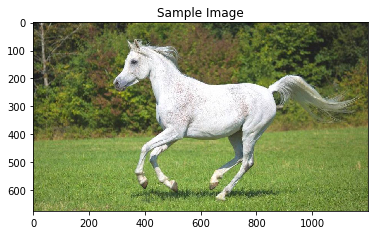

Predicted caption: <start> a a a a a a a a a a a a a a a a a a a


In [33]:
predict_from_image(test_image_file)

In [34]:
model_trained_on_device = str(next(encoder.parameters()).device)

In [35]:
model_trained_on_device

'cpu'

# Loading weights for CPU model while trained on GPU

- [pytorch discuss](https://discuss.pytorch.org/t/loading-weights-for-cpu-model-while-trained-on-gpu/1032/9)
- [Saving & Loading Model Across Devices](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-across-devices) [best answer]

```py
use_cuda = torch.cuda.is_available()
DEVICE = torch.device('cuda' if use_cuda else 'cpu')   # 'cpu' in this case

cpu_model = your_model()
cpu_model.load_state_dict(torch.load(path_to_your_saved_gpu_model, map_location=DEVICE)

```